# Code Technical Debt Identification

| **Metrics**                     | **Description**                                                                                                                                                        |
|---------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `commits_count`                 | Total number of commits made to a file in the evolution period.                                                                                                         |
| `code_churn_avg`                | Average size of a code churn of a file in the evolution period.                                                                                                         |
| `contributors_count`            | Total number of contributors who modified a file in the evolution period.                                                                                               |
| `contributors_experience`       | Percentage of the lines authored by the highest contributor of a file in the evolution period.                                                                          |
| `hunks_count`                   | Median number of hunks made to a file in the evolution period. A hunk is a continuous block of changes in a diff. This assesses how fragmented the commit file is.      |
| `issue_tracker_issues`          | Total number of times a file name has been reported in the project's Jira or GitHub issue tracker (mentioned either in the title or the body of the registered issue).  |
| `cbo`                           | Coupling between objects. This metric counts the number of dependencies a file has.                                                                                     |
| `wmc`                           | Weight Method Class or McCabe’s complexity. This metric counts the number of branch instructions in a file.                                                             |
| `dit`                           | Depth Inheritance Tree. This metric counts the number of “fathers” a file has.                                                                                          |
| `rfc`                           | Response for a Class. This metric counts the number of unique method invocations in a file.                                                                             |
| `lcom`                          | Lack of Cohesion in Methods. This metric counts the sets of methods in a file that are not related through the sharing of some of the file’s fields.                    |
| `max_nested_blocks`             | Highest number of code blocks nested together in a file.                                                                                                               |
| `total_methods`                 | Total number of methods in a file.                                                                                                                                      |
| `total_variables`               | Total number of declared variables in a file.                                                                                                                           |
| `total_refactorings`            | Total number of refactorings for a file in the evolution period.                                                                                                        |
| `duplicated_lines_density`      | Percentage of lines in a file involved in duplications (100 * duplicated_lines / lines_of_code). The minimum length which should be reported as a duplicate is set to 100.|
| `ncloc`                         | Number of non-commented lines of code in a file, ignoring empty lines and comments.                                                                                     |


## Setup

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.layers import Dense, Dropout

#Oversampling
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline
#Models
from sklearn.tree import DecisionTreeClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier

In [188]:
SEED_VALUE = 42


random.seed(SEED_VALUE)

In [189]:
#ctd -> code technical debt - data frame
ctd_df = pd.read_csv('dataset_final.csv')

In [190]:
ctd_df.head(10)

,Max-Ruler,commits_count,code_churn_avg,contributors_count,contributors_experience,hunks_count,issue_tracker_issues,cbo,wmc,dit,rfc,lcom,total_methods,max_nested_blocks,total_variables,total_refactorings,ncloc_cloc,duplicated_lines_cpd_density,comment_lines_cloc_density
0,1,11.0,65.0,3.0,81.63,1.0,16,3.0,108.0,1.0,74.0,774.0,40.0,3.0,66.0,30,410.0,0.0,35.736677
1,1,34.0,29.0,8.0,73.57,4.5,217,14.0,46.0,6.0,130.0,144.0,20.0,4.0,93.0,41,799.0,0.0,4.540024
2,1,184.0,5.0,12.0,37.28,2.0,40,34.0,188.0,1.0,163.0,1635.0,59.0,5.0,108.0,276,698.0,0.0,18.171161
3,1,21.0,17.0,6.0,53.60,1.0,9,9.0,103.0,1.0,36.0,183.0,26.0,4.0,30.0,14,310.0,0.0,0.958466
4,0,38.0,10.0,6.0,52.14,2.5,1,10.0,19.0,6.0,74.0,55.0,14.0,2.0,31.0,31,276.0,0.0,14.285714
5,1,16.0,30.0,4.0,83.39,2.0,2,8.0,53.0,6.0,78.0,94.0,17.0,6.0,38.0,14,347.0,0.0,12.814070
6,0,28.0,6.0,9.0,58.56,1.0,4,6.0,27.0,6.0,37.0,178.0,21.0,2.0,15.0,59,157.0,0.0,8.187135
7,0,2.0,88.0,1.0,100.00,1.0,0,8.0,8.0,6.0,36.0,1.0,3.0,3.0,21.0,0,125.0,0.0,18.831169
8,0,7.0,28.0,1.0,100.00,6.0,0,3.0,13.0,6.0,52.0,53.0,11.0,0.0,15.0,2,131.0,0.0,21.556886
9,0,11.0,25.0,4.0,45.40,4.0,0,5.0,12.0,6.0,40.0,9.0,6.0,1.0,20.0,59,198.0,0.0,17.154812


In [191]:
ctd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17797 entries, 0 to 17796
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Max-Ruler                     17797 non-null  int64  
 1   commits_count                 17797 non-null  float64
 2   code_churn_avg                17797 non-null  float64
 3   contributors_count            17797 non-null  float64
 4   contributors_experience       17797 non-null  float64
 5   hunks_count                   17797 non-null  float64
 6   issue_tracker_issues          17797 non-null  int64  
 7   cbo                           17797 non-null  float64
 8   wmc                           17797 non-null  float64
 9   dit                           17797 non-null  float64
 10  rfc                           17797 non-null  float64
 11  lcom                          17797 non-null  float64
 12  total_methods                 17797 non-null  float64
 13  m

In [192]:
ctd_df.describe()

,Max-Ruler,commits_count,code_churn_avg,contributors_count,contributors_experience,hunks_count,issue_tracker_issues,cbo,wmc,dit,rfc,lcom,total_methods,max_nested_blocks,total_variables,total_refactorings,ncloc_cloc,duplicated_lines_cpd_density,comment_lines_cloc_density
count,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000,17797.000000
mean,0.067034,11.110075,27.312862,3.499803,77.906843,1.761758,10.083048,7.440748,17.497556,2.037759,14.151205,63.580997,8.677137,1.311626,9.535427,15.658819,97.528516,4.851571,39.143383
std,0.250088,15.917221,44.888013,2.703207,20.995250,1.265538,53.049656,7.904609,28.958399,1.837410,22.583650,331.961231,12.042250,1.491109,18.302319,52.230184,142.377548,20.257659,21.790480
min,0.000000,1.000000,-2.000000,1.000000,17.640000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,3.000000,9.000000,2.000000,60.490000,1.000000,0.000000,2.000000,3.000000,1.000000,1.000000,0.000000,2.000000,0.000000,1.000000,1.000000,23.000000,0.000000,22.368421
50%,0.000000,7.000000,16.000000,3.000000,82.950000,1.500000,0.000000,5.000000,8.000000,1.000000,7.000000,2.000000,5.000000,1.000000,4.000000,1.000000,51.000000,0.000000,36.363636
75%,0.000000,13.000000,30.000000,4.000000,98.320000,2.000000,3.000000,10.000000,19.000000,2.000000,17.000000,16.000000,10.000000,2.000000,10.000000,9.000000,110.000000,0.000000,53.703704
max,1.000000,317.000000,1543.000000,45.000000,100.000000,26.500000,1187.000000,109.000000,453.000000,52.000000,293.000000,7503.000000,256.000000,21.000000,305.000000,1024.000000,1903.000000,537.500000,94.117647


## Exploratory Analysis

Amount of classes classified as HIGH_TD: 1193
Amount of classes classified as LOW_TD: 16604


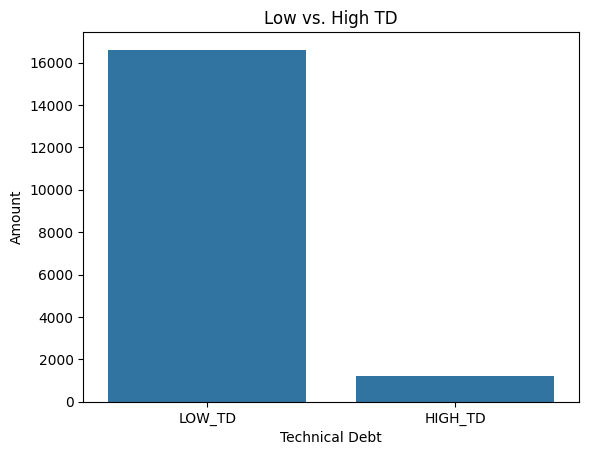

In [193]:
print(f"Amount of classes classified as HIGH_TD: {ctd_df[ctd_df['Max-Ruler'] == 1]['Max-Ruler'].count()}")
print(f"Amount of classes classified as LOW_TD: {ctd_df[ctd_df['Max-Ruler'] == 0]['Max-Ruler'].count()}")

# Amount of classes classified as HIGH vs LOW TD
sns.countplot(x='Max-Ruler', data=ctd_df)
plt.xlabel('Technical Debt')
plt.ylabel('Amount')
plt.title('Low vs. High TD')
plt.xticks([0, 1], ['LOW_TD', 'HIGH_TD'])
plt.show()

From the histogram plot, we can say that the number of values in each class is enormously different. So we have a imbalance in the dataset, it will be necessary to use techniques such as SMOTE to over sambple the class with lower amount.

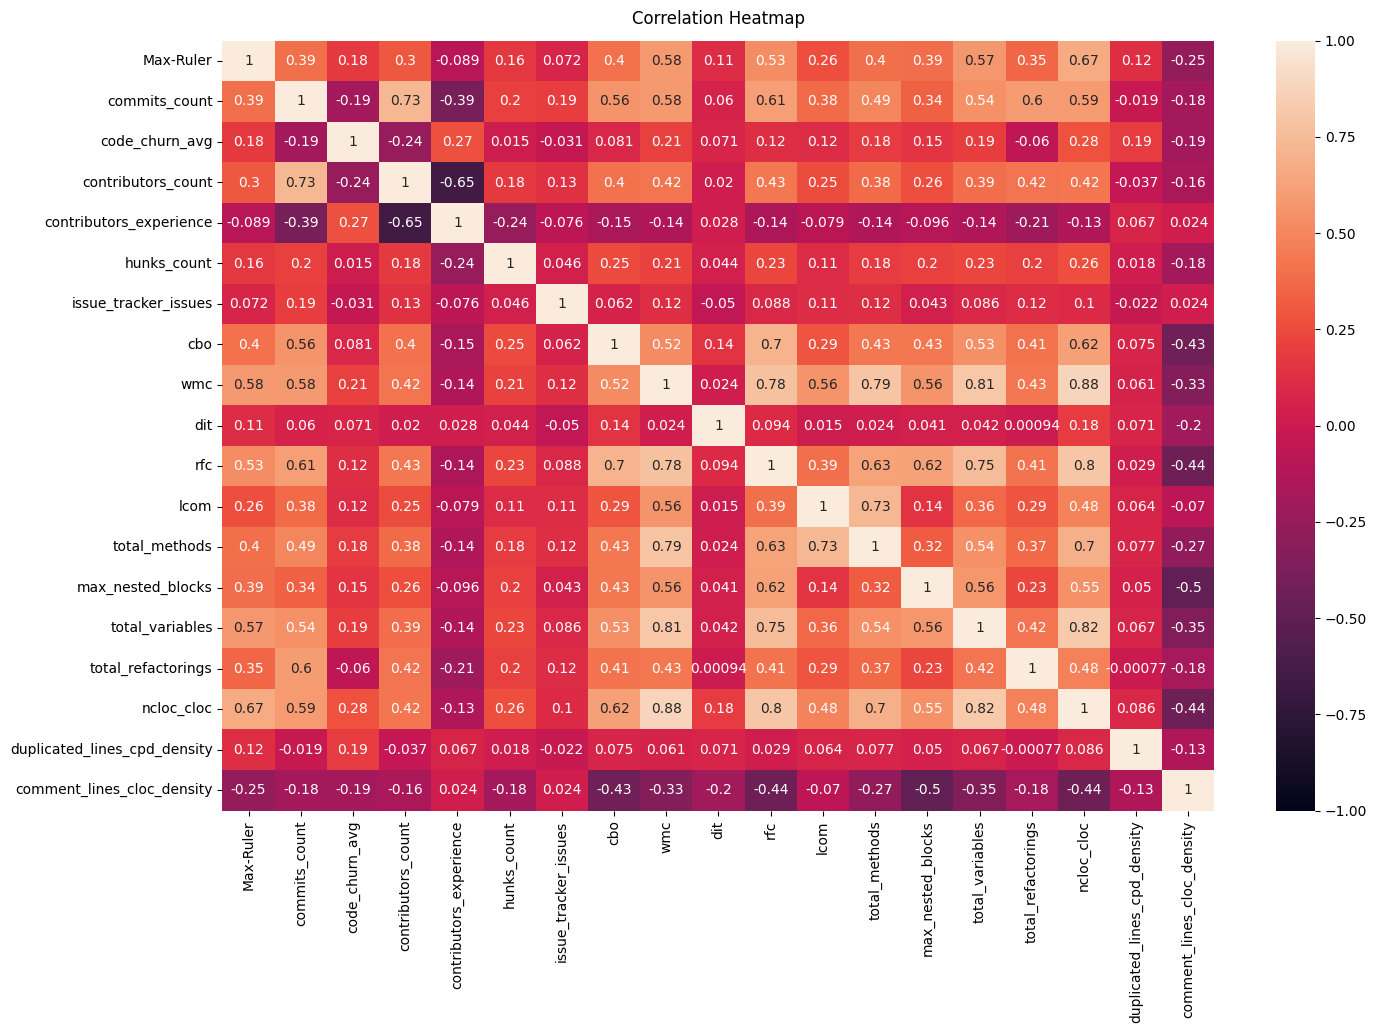

In [194]:
plt.figure(figsize=(16, 10))

correlation_matrix_ctd_df = ctd_df.corr()
heatmap = sns.heatmap(correlation_matrix_ctd_df, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [195]:
# Extracting the correlations of Max-Ruler with all other features
feature_correlation = correlation_matrix_ctd_df['Max-Ruler'].drop('Max-Ruler')

# Converting the correlations to a DataFrame for easier plotting
correlation_df = feature_correlation.reset_index()
correlation_df.columns = ['Feature', 'Correlation']

fig = px.bar(correlation_df, x='Correlation', y='Feature', orientation='h',
             title='Correlation of Max-Ruler with other features')

fig.show()

## Data Split

In [196]:
X = ctd_df.drop('Max-Ruler', axis=1)
y = ctd_df['Max-Ruler']

# creation of train and test dataset
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED_VALUE, stratify=y)
X_train_splited, X_valid, y_train_splited, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.1765, random_state=SEED_VALUE, stratify=y_train_all)
#Train 70% Test 15% Valid 15%

## Create Pipeline

In [197]:
def create_pipeline(model):
        return Pipeline(steps=[
                ('over', SMOTE(sampling_strategy=1,random_state=SEED_VALUE)),
                ('scale', MinMaxScaler()), 
                ('model', model)
        ])

## Metrics

In [ ]:
#How well does the model perform when it's more important to avoid false negatives than false positives?
                                                                   #High-TD classes that are classified as Low-TD
f2_score = metrics.make_scorer(metrics.fbeta_score, beta=2)

## Models Training

### DecisionTree

In [198]:
dt_classifier = DecisionTreeClassifier(random_state=SEED_VALUE)
pipeline = create_pipeline(dt_classifier)
scores = cross_val_score(pipeline, X_train_all, y_train_all, cv=10, scoring='accuracy')

In [199]:
print("Average cross-validation score:", scores.mean())

Average cross-validation score: 0.940996538320215


In [200]:
pipeline.fit(X_train_all, y_train_all)
y_pred = pipeline.predict(X_test)

In [201]:
#evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Accuracy: 0.9398876404494382
Precision: 0.5403050108932462
Recall: 0.6927374301675978
F1-score: 0.6070991432068543
Confusion matrix:
 [[4771  211]
 [ 110  248]]


In [202]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4982
           1       0.54      0.69      0.61       358

    accuracy                           0.94      5340
   macro avg       0.76      0.83      0.79      5340
weighted avg       0.95      0.94      0.94      5340



Grid Search

In [203]:
dt_classifier = DecisionTreeClassifier(random_state=SEED_VALUE)
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [210]:
pipeline = create_pipeline(dt_classifier)

grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = {
        'accuracy': 'accuracy',
        'f2': f2_score
}, cv = 10, n_jobs = -1, refit='f2',verbose=1)

In [212]:
grid_search.fit(X_train_all, y_train_all)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 5, 10, 15],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             refit='f2',
             scoring={'accuracy': 'accuracy',
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2)},
             verbose=1)

In [208]:
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best score: 0.7204939908571406


In [134]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [136]:
#evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Accuracy: 0.8917602996254682
Precision: 0.37723214285714285
Recall: 0.9441340782122905
F1-score: 0.5390749601275917
Confusion matrix:
 [[4424  558]
 [  20  338]]


In [138]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      4982
           1       0.38      0.94      0.54       358

    accuracy                           0.89      5340
   macro avg       0.69      0.92      0.74      5340
weighted avg       0.95      0.89      0.91      5340



### Random Forest

In [220]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1)
pipeline = create_pipeline(model)
param_grid = {
    'model__n_estimators': [5, 10, 50, 100, 300, 500, 1000],
    'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
    'model__min_samples_leaf': [1, 2, 5],
    'model__criterion': ['gini', 'entropy']
}

In [221]:
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = {
        'accuracy': 'accuracy',
        'f2': f2_score
}, cv = 10, n_jobs = -1, refit='f2',verbose=1)

In [222]:
grid_search.fit(X_train_all, y_train_all)

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             refit='f2',
             scoring={'accuracy': 'accuracy',
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2)},
             verbose=1)

In [224]:
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
Best score: 0.7812237228589181


### KerasClassifier

In [172]:
#buil model func
def build_model(activation='relu', neurons=128, num_hidden_layers=2, optimizer='adam'):
  model = Sequential()
  model.add(Input(shape=(X_train_splited.shape[1], )))
  model.add(Dense(neurons, activation=activation))

  # Add hidden layers
  num_hidden_layers -= 1
  for _ in range(num_hidden_layers):
    model.add(Dense(neurons, activation=activation))

  # Output layer
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [175]:
model = KerasClassifier(model=build_model, epochs=21, batch_size=64, verbose=1, random_state=SEED_VALUE)

pipeline = create_pipeline(model)

# hyperparameters to search
param_grid = {
    'model__model__activation': ['relu', 'sigmoid'],
    'model__model__neurons': [128, 200, 300, 400, 500],
    'model__model__num_hidden_layers': [2, 3, 4, 5],
    'model__model__optimizer': ['adam', 'rmsprop', 'sgd']
}

#GridSearch
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f2_score, cv=5, n_jobs=-1)

# Run the grid search
grid_result = grid.fit(X_train_splited, y_train_splited, model__validation_data=(X_valid, y_valid))

Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8492 - loss: 0.6668 - val_accuracy: 0.6012 - val_loss: 5.3739
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8167 - loss: 0.6700 - val_accuracy: 0.6039 - val_loss: 5.1224
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8618 - loss: 0.6176 - val_accuracy: 0.5575 - val_loss: 12.6372
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8793 - loss: 0.6060 - val_accuracy: 0.5671 - val_loss: 13.8911
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8696 - loss: 0.4126 - val_accuracy: 0.3415 - val_loss: 319.6393
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8704 - loss: 0.4216 - val_accuracy: 0.3370 - val_loss: 330.2085
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8638 - loss: 0.5650 - val_accuracy: 0.5271 - val_loss: 24.6695
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

In [176]:
# Display best result with hyperparameters
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.754123904027439 using {'model__model__activation': 'relu', 'model__model__neurons': 128, 'model__model__num_hidden_layers': 5, 'model__model__optimizer': 'rmsprop'}
